<a href="https://colab.research.google.com/github/kurihara-ryo/cesarean-pasaran/blob/main/%E3%80%90%E8%A7%A3%E7%AD%94%E4%BE%8B%E3%80%91%E6%BC%94%E7%BF%92%E8%AA%B2%E9%A1%8C_%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E2%85%A2_1920.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#【課題】と書いてあるセルでは、自分でプログラムを作成してください。
# 実行ボタンを押してプログラムの動作確認を行い、Google Classroomから提出してください。
# 提出する際は、コメント(#から始まる部分)を削除せずに残してください。
# 〆切が近いので、後回しにせず講義時間中に手を動かしてプログラムを作成すること。

In [ ]:
#### 大規模データに対する深層学習
# 大規模データの例として、Fashion MNISTデータセットを使用します。
# 学習データ数50000、バリデーションデータ数10000、テストデータ数10000です。

# 必要なモジュール一式を準備
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# 乱数シードの設定
seed = 42 # 変更しない
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# データセットの読み込み
# torchvisionモジュールを使って、Fashion MNISTデータセットを読み込みます。
# transformには、読み込みと同時に行う前処理を指定します。
# ここではテンソルへの変換を行っています。
# rootには、ダウンロードしたファイルの保存先ディレクトリを指定します。
# 今回はGoogle Colab内に保存するので、適当なディレクトリでOKです。
transform = transforms.ToTensor()
train_val_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
print('\n')

# 学習データとバリデーションデータの分割
# torchのrandom_split()を使って、train_val_datasetをランダムに分割します。
# 今回は学習データ50000個、バリデーションデータ10000個に分割しています。
train_dataset, val_dataset = random_split(train_val_dataset, [50000, 10000])

# データ数を表示
# テストデータは10000個です。
print('Train data size: {}'.format(len(train_dataset)))
print('Val data size: {}'.format(len(val_dataset)))
print('Test data size: {}'.format(len(test_dataset)))

Random seed: 42


100%|██████████| 26.4M/26.4M [00:01<00:00, 22.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 337kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.23MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.8MB/s]



Train data size: 50000
Val data size: 10000
Test data size: 10000


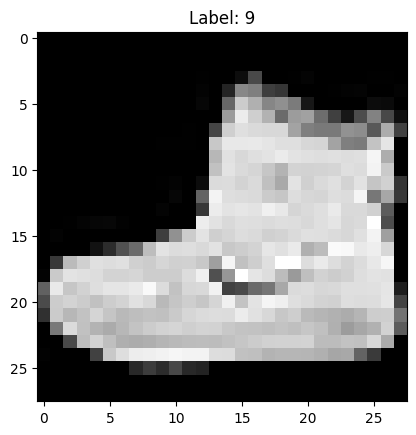

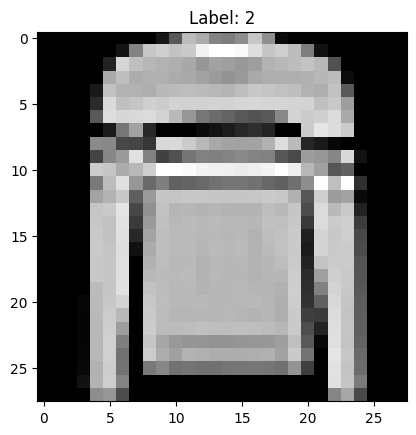

In [ ]:
# データセットの中身を確認します。
# 各データは画像とラベルのペアからなります。
# 画像はチャネル数1、高さ28ピクセル、幅28ピクセルの白黒画像を表すテンソル、
# ラベルは10個のクラスどれかを表す整数(0, 1, ..., 9)です。
# matplotlibで表示してみます。

# 0番目のデータ
image, label = train_val_dataset[0]
# imageはshape (1, 28, 28)で、最初の次元はチャネル数
# matplotlibで表示するため、最初の次元を削除してshape (28, 28)に変換
image = image.squeeze(0)
# imsshow()で画像をグレースケールで表示
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

# 5番目のデータも表示
image, label = train_val_dataset[5]
image = image.squeeze(0)
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

# 0番目の画像のラベルは9：Ankle boot(アンクルブーツ)
# 5番目の画像のラベルは2：Pullover(プルオーバー、頭から被って着る服)

In [ ]:
# 10クラスのマルチクラス分類モデルを作成します。
# まずは、シンプルな多層パーセプトロンを考えます。
# 入力の画像データはshape (1, 28, 28)のテンソルですが、
# 多層パーセプトロンで扱うデータは1次元テンソル(ベクトル)にする必要があります。
# そのため以下の例では、ネットワーク構造の定義において、
# nn.Flatten()を使ってテンソルを1次元に変換する処理を入れています。
# それ以外の部分は第15,16回の演習課題と同様の流れです。

# 乱数シードの設定
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# ネットワーク構造の定義
model = nn.Sequential(
    nn.Flatten(),          # 1次元に変換
    nn.Linear(28*28, 256), # (1, 28, 28)を1次元に変換したので、入力のユニット数は28*28
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)     # logitsを出力
)

# 損失関数の定義
# マルチクラス分類用の交差エントロピー誤差nn.CrossEntropyLoss()を用いる。
# 前回使用した2クラス分類用のnn.BCEWithLogitsLoss()のマルチクラス版。
# クラス確率ではなくlogitsを引数とする点も同様。
criterion = nn.CrossEntropyLoss()

# SGDの定義
optimizer = optim.SGD(model.parameters(), lr=0.001)

# バッチサイズの指定
# shuffle=Trueとすると、エポックごとにデータの順番をランダムに並び替える。
# 学習後の汎化性能が良くなることがある。
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 学習ループ
# データ数が多いため、10エポックでも計算時間かかる。
for epoch in range(10):
    model.train() # 学習モード：後で説明
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    avg_loss = epoch_loss / len(train_loader.dataset)
    print('Epoch {}, Loss: {}'.format(epoch, avg_loss))

Random seed: 42
Epoch 0, Loss: 2.2722601040649413
Epoch 1, Loss: 2.187280522918701
Epoch 2, Loss: 2.0329482872009277
Epoch 3, Loss: 1.7821661019897461
Epoch 4, Loss: 1.512087251815796
Epoch 5, Loss: 1.302744469833374
Epoch 6, Loss: 1.1565939561843872
Epoch 7, Loss: 1.0532730700874329
Epoch 8, Loss: 0.9772792803001403
Epoch 9, Loss: 0.9199367595291138


In [ ]:
# テストデータに対するaccuracyを評価します。
# マルチクラス分類のaccuracyを計算する場合、
# accuracy_score()にはクラスラベルの整数が入ったリストを渡します。

# accuracyの計算は何度も行うので関数にしておきます。
# モデルとデータを引数として、accuracyを戻り値とする関数。
def evaluate(model, dataloader):
    model.eval() # 評価モード：後で説明
    y_true_list = []
    y_pred_list = []
    with torch.no_grad():
        for X, y in dataloader:
            # logitsを計算
            outputs = model(X)
            # logitsの最も大きいクラスに割り当てる
            # argmax()は最も大きい要素のインデックス(整数)を返す
            preds = torch.argmax(outputs, dim=1)
            # extend()はリストの連結を行う
            y_true_list.extend(y.numpy())
            y_pred_list.extend(preds.numpy())
    acc = accuracy_score(y_true_list, y_pred_list)
    return acc


# テストデータのdataloaderを作成
test_loader = DataLoader(test_dataset, batch_size=64)
# テストデータに対するaccuracyを評価
test_acc = evaluate(model, test_loader)
print('Accuracy on test data: {}'.format(test_acc))

Accuracy on test data: 0.6627


【課題】上の例にならって、隠れ層1のユニット数を512、隠れ層2のユニット数を256に変更したネットワークを作成して、各エポックの損失関数の値を表示してください。学習後のモデルを使って、テストデータに対するaccuracyを計算して表示してください。それ以外の設定は上の例と同じにしてください。

In [ ]:
# 乱数シードの設定
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# ネットワーク構造の定義
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# SGDの定義
optimizer = optim.SGD(model.parameters(), lr=0.001)

# バッチサイズの指定
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 学習ループ
for epoch in range(10):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    avg_loss = epoch_loss / len(train_loader.dataset)
    print('Epoch {}, Loss: {}'.format(epoch, avg_loss))

# テストデータのdataloaderを作成
test_loader = DataLoader(test_dataset, batch_size=64)
# テストデータに対するaccuracyを評価
test_acc = evaluate(model, test_loader)
print('Accuracy on test data: {}'.format(test_acc))

Random seed: 42
Epoch 0, Loss: 2.2664272059631347
Epoch 1, Loss: 2.1580254122161864
Epoch 2, Loss: 1.9752341066741943
Epoch 3, Loss: 1.70772761013031
Epoch 4, Loss: 1.4419295090866089
Epoch 5, Loss: 1.2404182201004028
Epoch 6, Loss: 1.0996125386047364
Epoch 7, Loss: 1.0016315516662597
Epoch 8, Loss: 0.9315865235137939
Epoch 9, Loss: 0.8796561162567139
Accuracy on test data: 0.6707


In [ ]:
#### GPUの利用
# GPUを使うことで計算を高速化できます。
# Google Colabの右上のメニューから「ランタイムのタイプを変更」を選択して
# ランタイムをT4 GPUに切り替えてください。
# なお、Google Colabの無料アカウントではGPUの使用時間に上限があります。
# 上限に到達してしまったら、ランタイムをCPUに戻しましょう。


In [ ]:
# ランタイムを切り替えたので、再度、初期設定を行います。

# 必要なモジュール一式を準備
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# 乱数シードの設定
seed = 42 # 変更しない
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# データセットの読み込み
transform = transforms.ToTensor()
train_val_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 学習データとバリデーションデータに分割
train_dataset, val_dataset = random_split(train_val_dataset, [50000, 10000])

Random seed: 42


100%|██████████| 26.4M/26.4M [00:02<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.49MB/s]


In [ ]:
# 以下のコードを実行すると、
# GPUが使える場合には変数deviceの値が'cuda'になります。
# GPUが使えない(CPUのみ使える)場合にはdeviceは'cpu'になります。
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

Using device: cpu


In [ ]:
# GPUを使用する場合、to(device)を使ってモデルをGPUに移動する必要があります。
# また、モデルの計算に必要な変数も同様にGPUに移動する必要があります。
# deviceが'cuda'ならGPU、deviceが'cpu'なら通常通りCPUを使用します。
# そのため、自分でコードを書くときには最初からto(device)を入れておく方が便利です。

# 乱数シードの設定
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# GPUを使えるか判定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

# ネットワーク構造の定義
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)
## ↑deviceが'cuda'ならモデルをGPUに移動
##   deviceが'cpu'なら通常通りCPUを使用

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# SGDの定義
optimizer = optim.SGD(model.parameters(), lr=0.001)

# バッチサイズの指定
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 学習ループ
for epoch in range(10):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        ## X_batchはモデルの計算に必要なのでGPUに移動
        ## y_batchも損失関数の計算に必要なのでGPUに移動
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    avg_loss = epoch_loss / len(train_loader.dataset)
    print('Epoch {}, Loss: {}'.format(epoch, avg_loss))

Random seed: 42
Using device: cpu
Epoch 0, Loss: 2.2722601040649413
Epoch 1, Loss: 2.187280522918701
Epoch 2, Loss: 2.0329482872009277
Epoch 3, Loss: 1.7821661019897461
Epoch 4, Loss: 1.512087251815796
Epoch 5, Loss: 1.302744469833374
Epoch 6, Loss: 1.1565939561843872
Epoch 7, Loss: 1.0532730700874329
Epoch 8, Loss: 0.9772792803001403
Epoch 9, Loss: 0.9199367595291138


In [ ]:
# accuracy計算の関数にも修正が必要です、
# モデルの計算に必要な変数XをGPUに移動します。
# また、Xを使って計算された変数predsはGPU側に作られるので、
# sklearnの関数に渡す際には、cpu()でCPU側に戻す必要があります。
# これらについても、自分でコードを書くときには最初から入れておく方が便利です。

def evaluate(model, dataloader):
    model.eval()
    y_true_list = []
    y_pred_list = []
    with torch.no_grad():
        for X, y in dataloader:
            ## Xはモデルの計算に必要なのでGPUに移動
            X = X.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            y_true_list.extend(y.numpy())
            ## preds.cpu()でCPUに戻す
            y_pred_list.extend(preds.cpu().numpy())
    acc = accuracy_score(y_true_list, y_pred_list)
    return acc

test_loader = DataLoader(test_dataset, batch_size=64)
test_acc = evaluate(model, test_loader)
print('Accuracy on test data: {}'.format(test_acc))

Accuracy on test data: 0.6627


In [ ]:
#### 改良型SGDの利用
# 「深層学習入門」第2回で学んだ改良型SGDを使用すると、
# 学習を安定させたり収束を早めることができます。
# 例として、現在最もよく使用されている手法であるAdamを使ってみます。
# 使い方は通常のSGDとほとんど同じです。

# 乱数シードの設定
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# GPUを使えるか判定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

# ネットワーク構造の定義
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# SGDの定義
# Adamを使用
optimizer = optim.Adam(model.parameters(), lr=0.001)

# バッチサイズの指定
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 学習ループ
for epoch in range(10):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    avg_loss = epoch_loss / len(train_loader.dataset)
    print('Epoch {}, Loss: {}'.format(epoch, avg_loss))


test_acc = evaluate(model, test_loader)
print('Accuracy on test data: {}'.format(test_acc))

# 通常のSGDと比較して学習後のlossが小さくなり、
# テストデータに対するaccuracyも高くなりました。

Random seed: 42
Using device: cpu
Epoch 0, Loss: 0.5547939810276031
Epoch 1, Loss: 0.38030759690284727
Epoch 2, Loss: 0.3435750722980499
Epoch 3, Loss: 0.317158204832077
Epoch 4, Loss: 0.299096561627388
Epoch 5, Loss: 0.28162264620184896
Epoch 6, Loss: 0.26694339205265044
Epoch 7, Loss: 0.2578299042034149
Epoch 8, Loss: 0.24586272143363952
Epoch 9, Loss: 0.23642131601333619
Accuracy on test data: 0.8747


【課題】「深層学習入門」第2回において、改良型SGDの1つとしてRMSpropについて学びました。上の例にならって、AdamをRMSpropに変更して、各エポックの損失関数の値を表示してください。学習後のモデルを使って、テストデータに対するaccuracyを計算して表示してください。それ以外の設定は上の例と同じにしてください。

通常のSGDと比較して、学習後のlossやテストデータに対するaccuracyはどうなりましたか？コメントの解答欄に書いてください。


In [ ]:
# 乱数シードの設定
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# GPUを使えるか判定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

# ネットワーク構造の定義
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# SGDの定義
# RMSpropを使用
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# バッチサイズの指定
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 学習ループ
for epoch in range(10):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    avg_loss = epoch_loss / len(train_loader.dataset)
    print('Epoch {}, Loss: {}'.format(epoch, avg_loss))


test_acc = evaluate(model, test_loader)
print('Accuracy on test data: {}'.format(test_acc))

#【解答欄】
# ここに解答を書いてください。
# 通常のSGDと比較して学習後のlossは0.92 --> 0.23と小さくなった。
# テストデータに対するaccuracyは0.66--> 0.88と高くなった。

Random seed: 42
Using device: cpu
Epoch 0, Loss: 0.5442892530822754
Epoch 1, Loss: 0.3861286721992493
Epoch 2, Loss: 0.3439986678981781
Epoch 3, Loss: 0.31688272253990174
Epoch 4, Loss: 0.2948024749755859
Epoch 5, Loss: 0.2783399308347702
Epoch 6, Loss: 0.2657232114624977
Epoch 7, Loss: 0.2526134718465805
Epoch 8, Loss: 0.24256887273788452
Epoch 9, Loss: 0.23288747489452363
Accuracy on test data: 0.8775


In [ ]:
#### バリデーションデータの利用
# 深層学習では、バリデーションデータを使用して過学習の検知やハイパラの調整を行います。
# 以下の例では、学習の各エポックでバリデーションデータに対する損失を評価しています。
# また、学習のエポック数を20に増やしています。

# 乱数シードの設定
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# GPUを使えるか判定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

# ネットワーク構造の定義
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# SGDの定義
optimizer = optim.Adam(model.parameters(), lr=0.001)

# dataloaderの作成
# 学習データ用、バリデーションデータ用、テストデータ用をそれぞれ作成
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# 学習ループ
# 20エポック回す
for epoch in range(20):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    # 学習データに対する損失
    avg_loss = epoch_loss / len(train_loader.dataset)
    # バリデーションデータに対する損失
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): # バリデーションデータの勾配は不要なので自動微分をOFF
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)
    # 学習データ、バリデーションデータに対する損失を表示
    print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(epoch, avg_loss, avg_val_loss))


# テストデータに対するaccuracy
test_acc = evaluate(model, test_loader)
print('Accuracy on test data: {}'.format(test_acc))

# 学習中、学習データに対する損失は下がり続けています。
# 一方、バリデーションデータに対する損失はEpoch 9あたりから低下しなくなり
# それ以降のEpochでは上昇していく傾向にあります。
# このことから過学習が起こっていると考えられます。

Random seed: 42
Using device: cpu
Epoch 0, Train Loss: 0.5547939810276031, Val Loss: 0.4049241940021515
Epoch 1, Train Loss: 0.38167404633522034, Val Loss: 0.36330958909988403
Epoch 2, Train Loss: 0.34457733348846437, Val Loss: 0.36022012333869935
Epoch 3, Train Loss: 0.32084663261413576, Val Loss: 0.33543130996227266
Epoch 4, Train Loss: 0.2970120664358139, Val Loss: 0.3201426437497139
Epoch 5, Train Loss: 0.28167706802129744, Val Loss: 0.3146257018685341
Epoch 6, Train Loss: 0.270006624712944, Val Loss: 0.3456172767162323
Epoch 7, Train Loss: 0.2583450923013687, Val Loss: 0.315134344291687
Epoch 8, Train Loss: 0.2433577919149399, Val Loss: 0.32200641182661055
Epoch 9, Train Loss: 0.23574478466033935, Val Loss: 0.2955359766721726
Epoch 10, Train Loss: 0.2237887127685547, Val Loss: 0.3579214657783508
Epoch 11, Train Loss: 0.21684333181381227, Val Loss: 0.30651279792785646
Epoch 12, Train Loss: 0.2057379571533203, Val Loss: 0.3087021566510201
Epoch 13, Train Loss: 0.20136573429107665, V

In [ ]:
#### ドロップアウトの導入
# 過学習を防ぐための手法として、
#「深層学習入門」第3回で学んだドロップアウトがあります。
# ネットワーク構造の定義においてnn.Dropout()を入れることで、
# その1つ前の層に対してドロップアウトを行うことができます。

# 乱数シードの設定
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# GPUを使えるか判定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

# ネットワーク構造の定義
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),             # このReLUの結果がランダムに0になる
    nn.Dropout(0.5),       # ドロップアウト(確率0.5)
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# SGDの定義
optimizer = optim.Adam(model.parameters(), lr=0.001)

# dataloaderの作成
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# 学習ループ
for epoch in range(20):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    # 学習データに対する損失
    avg_loss = epoch_loss / len(train_loader.dataset)
    # バリデーションデータに対する損失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)
    # 学習データ、バリデーションデータに対する損失を表示
    print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(epoch, avg_loss, avg_val_loss))


# テストデータに対するaccuracy
test_acc = evaluate(model, test_loader)
print('Accuracy on test data: {}'.format(test_acc))

# 学習の後半、バリデーションデータの損失が上昇する傾向が弱くなりました。
# このことから、過学習をある程度低減できていると言えそうです。
# 一方、学習データの損失は学習によって低下しているものの、ドロップアウトなしの場合より高くなっています。
# このように、ドロップアウトを行うと学習データへのフィッティングは悪くなることが多いです。
# テストデータに対するaccuracyは0.88であり、
# ドロップアウトなしの場合とあまり変わりません。

Random seed: 42
Using device: cpu
Epoch 0, Train Loss: 0.6300883201694488, Val Loss: 0.4444670174360275
Epoch 1, Train Loss: 0.4541747616481781, Val Loss: 0.3850455300807953
Epoch 2, Train Loss: 0.41776053621292114, Val Loss: 0.36552734005451204
Epoch 3, Train Loss: 0.3969711669826508, Val Loss: 0.3804621128797531
Epoch 4, Train Loss: 0.3824440495014191, Val Loss: 0.356860085439682
Epoch 5, Train Loss: 0.36837677913665773, Val Loss: 0.34066004927158355
Epoch 6, Train Loss: 0.35749769211292265, Val Loss: 0.3354764726638794
Epoch 7, Train Loss: 0.34902029572486876, Val Loss: 0.32951362130641937
Epoch 8, Train Loss: 0.3418429273509979, Val Loss: 0.334777814912796
Epoch 9, Train Loss: 0.3365267326259613, Val Loss: 0.3182085011959076
Epoch 10, Train Loss: 0.32978487602233886, Val Loss: 0.31861111223697663
Epoch 11, Train Loss: 0.32410105884552004, Val Loss: 0.32227389376163484
Epoch 12, Train Loss: 0.3189131157398224, Val Loss: 0.3129680426597595
Epoch 13, Train Loss: 0.3142433122110367, Va

In [ ]:
#### model.train(), model.eval()
# ニューラルネットワークのレイヤーの中には、学習時と予測時で処理の異なるものがあります。
# 例えば、ドロップアウトは、
# 学習時にはユニットの出力を一定の確率で0にする(ユニットを削除する)処理を行いますが、
# 予測時には全てのユニットを使用して出力を計算します。
# 今まで使ってきたmodel.train(), model.eval()は、
# このような学習時と予測時の動作の切り替えを行う機能を持っています。
# 自分でコードを書くときには、いつも入れておくのが安全です。

In [ ]:
#### バッチ正規化の導入
# 学習の数値的安定性を高めるための手法として、
# 「深層学習入門」第3回で学んだバッチ正規化があります。
# ネットワーク構造の定義においてnn.BatchNorm1d()を入れることで、
# その1つ前の層の出力に対してバッチ正規化を行うことができます。

# 乱数シードの設定
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# GPUを使えるか判定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

# ネットワーク構造の定義
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.BatchNorm1d(256),   # 1つ前のLinear層の出力をバッチ正規化
    nn.ReLU(),
    nn.Dropout(0.5),       # ドロップアウトも使用
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),   # 1つ前のLinear層の出力をバッチ正規化
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# SGDの定義
optimizer = optim.Adam(model.parameters(), lr=0.001)

# dataloaderの作成
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# 学習ループ
for epoch in range(20):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    # 学習データに対する損失
    avg_loss = epoch_loss / len(train_loader.dataset)
    # バリデーションデータに対する損失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)
    # 学習データ、バリデーションデータに対する損失を表示
    print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(epoch, avg_loss, avg_val_loss))


# テストデータに対するaccuracy
test_acc = evaluate(model, test_loader)
print('Accuracy on test data: {}'.format(test_acc))


# バリデーションデータの損失は上昇しておらず、
# 学習データの損失もドロップアウトのみの場合より小さくなりました。
# 一方、テストデータに対するaccuracyは0.89であり、
# 先程までのモデルとあまり変わりません。

Random seed: 42
Using device: cpu
Epoch 0, Train Loss: 0.5516651962661743, Val Loss: 0.4354554348945618
Epoch 1, Train Loss: 0.42528948493003843, Val Loss: 0.3720967957496643
Epoch 2, Train Loss: 0.3919573538780212, Val Loss: 0.35312238719463346
Epoch 3, Train Loss: 0.36853630029678347, Val Loss: 0.33329965550899504
Epoch 4, Train Loss: 0.35640258535385133, Val Loss: 0.3269489110708237
Epoch 5, Train Loss: 0.3407185674476624, Val Loss: 0.31668895487785337
Epoch 6, Train Loss: 0.33065053926467897, Val Loss: 0.3154347938299179
Epoch 7, Train Loss: 0.3187043284416199, Val Loss: 0.3119892119407654
Epoch 8, Train Loss: 0.31296337824821474, Val Loss: 0.3095575761079788
Epoch 9, Train Loss: 0.30212648568153383, Val Loss: 0.3058978836774826
Epoch 10, Train Loss: 0.2952130706977844, Val Loss: 0.304269549369812
Epoch 11, Train Loss: 0.2919199090385437, Val Loss: 0.2990282628059387
Epoch 12, Train Loss: 0.28302521164894107, Val Loss: 0.30072348308563235
Epoch 13, Train Loss: 0.27724399882793427, 

【課題】上の例にならって、ドロップアウトとバッチ正規化を導入したネットワークに対して、ドロップアウト確率を0.3に変更して、各エポックにおける学習データの損失、バリデーションデータの損失を表示してください。また、テストデータに対するaccuracyを計算して表示してください。それ以外の設定は上の例と同じにしてください。

In [ ]:
# 乱数シードの設定
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# GPUを使えるか判定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

# ネットワーク構造の定義
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.3),       # ドロップアウト確率を0.3に設定
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# SGDの定義
optimizer = optim.Adam(model.parameters(), lr=0.001)

# dataloaderの作成
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# 学習ループ
for epoch in range(20):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    # 学習データに対する損失
    avg_loss = epoch_loss / len(train_loader.dataset)
    # バリデーションデータに対する損失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)
    # 学習データ、バリデーションデータに対する損失を表示
    print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(epoch, avg_loss, avg_val_loss))


# テストデータに対するaccuracy
test_acc = evaluate(model, test_loader)
print('Accuracy on test data: {}'.format(test_acc))

Random seed: 42
Using device: cpu
Epoch 0, Train Loss: 0.5094331258392334, Val Loss: 0.4274532521724701
Epoch 1, Train Loss: 0.3870658652687073, Val Loss: 0.3544882797718048
Epoch 2, Train Loss: 0.35022201350212095, Val Loss: 0.3372200974225998
Epoch 3, Train Loss: 0.3259115677833557, Val Loss: 0.32081438987255095
Epoch 4, Train Loss: 0.3126559733772278, Val Loss: 0.3045757827281952
Epoch 5, Train Loss: 0.29747344458580016, Val Loss: 0.30528345670700074
Epoch 6, Train Loss: 0.28487977198600767, Val Loss: 0.3029666917085648
Epoch 7, Train Loss: 0.27288981605529783, Val Loss: 0.3145903688907623
Epoch 8, Train Loss: 0.26177658328056336, Val Loss: 0.31448354811668394
Epoch 9, Train Loss: 0.25501125589370727, Val Loss: 0.3011355150103569
Epoch 10, Train Loss: 0.24616671602249146, Val Loss: 0.2942640570163727
Epoch 11, Train Loss: 0.23835686042785645, Val Loss: 0.31115437541007995
Epoch 12, Train Loss: 0.2333948631000519, Val Loss: 0.30501475112438203
Epoch 13, Train Loss: 0.2242721912002563

In [ ]:
#### 畳み込みニューラルネットワーク(CNN)
# CNNを使用する場合も、多層パーセプトロンと同様に、
# レイヤーを部品のように組み合わせてネットワーク構造を定義します。
# torch.nnに畳み込みやプーリングのクラスが用意されています。

# nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
# 画像のような2次元データに対して畳み込み演算を行うレイヤー。
# 入力のshapeは3次元(チャネル, 高さ, 幅)
# 主な引数として、入力チャネル数、出力チャネル数(フィルタ数)、
# カーネル(フィルタ)のサイズ、ストライド、パディングするピクセル数などを指定。

# nn.MaxPool2d(kernel_size, stride)
# 画像のような2次元データに対して最大プーリングを行うレイヤー。
# 入力のshapeは3次元(チャネル, 高さ, 幅)
# 主な引数として、カーネル(フィルタ)のサイズなどを指定。

# ネットワーク構造の定義
# Fashion MNISTの画像データのshapeは(1, 28, 28)なので、
# 最初の畳み込み層のin_channelsは1とします。
model = nn.Sequential(
    # 畳み込み＆プーリング1
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 畳み込み＆プーリング2
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # nn.Flatten()で1次元に変換して全結合層へ
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 128), # 入力のユニット数に注意
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

In [ ]:
# 全結合層に繋げる部分のユニット数の指定には注意が必要です。
# カーネルサイズ、ストライド、パディングなどを考慮して、
# shapeがどのように変化していくか考える必要があります。

# ネットワーク構造の定義
model = nn.Sequential(
    # 入力画像は(1, 28, 28)

    # 畳み込み＆プーリング1
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    # フィルタ数32で畳み込みしたのでチャネル数は32に増える。
    # カーネルサイズ3、パディング1なので、高さ、幅は変わらない。
    # そのためshapeは(32, 28, 28)となる。
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 最大プーリングではチャネル数は変わらない。
    # カーネルサイズ2、ストライド2なので、高さ、幅は半分になる。
    # そのためshapeは(32, 14, 14)となる。

    # 畳み込み＆プーリング2
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    # フィルタ数64で畳み込みしたのでチャネル数は64に増える。
    # カーネルサイズ3、パディング1なので、高さ、幅は変わらない。
    # そのためshapeは(64, 14, 14)となる。
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 最大プーリングではチャネル数は変わらない。
    # カーネルサイズ2、ストライド2なので、高さ、幅は半分になる。
    # そのためshapeは(64, 7, 7)となる。

    # (64, 7, 7)を1次元に変換
    nn.Flatten(),
    # そのため入力のユニット数は64 * 7 * 7となる
    nn.Linear(64 * 7 * 7, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

In [ ]:
# ネットワークを定義した後の流れは、これまでと同様です。
# CNNの計算は、GPUを使用するとかなり高速化します。
# CPUしか使えないと計算は重いです。

# 乱数シードの設定
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# GPUを使えるか判定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

# ネットワーク構造の定義
model = nn.Sequential(
    # 畳み込み＆プーリング1
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 畳み込み＆プーリング2
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 全結合層
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
).to(device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# SGDの定義
optimizer = optim.Adam(model.parameters(), lr=0.001)

# dataloaderの作成
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# 学習ループ
for epoch in range(20):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    # 学習データに対する損失
    avg_loss = epoch_loss / len(train_loader.dataset)
    # バリデーションデータに対する損失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)
    # 学習データ、バリデーションデータに対する損失を表示
    print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(epoch, avg_loss, avg_val_loss))


# テストデータに対するaccuracy
test_acc = evaluate(model, test_loader)
print('Accuracy on test data: {}'.format(test_acc))

# テストデータに対するaccuracyは0.91となり、多層パーセプトロンより高くなりました。
# 一方、学習中にバリデーションデータの損失が上昇しており、過学習の傾向が見られます。

Random seed: 42
Using device: cpu
Epoch 0, Train Loss: 0.48517267895698546, Val Loss: 0.35779689018726346
Epoch 1, Train Loss: 0.30864957421302797, Val Loss: 0.3014959420681
Epoch 2, Train Loss: 0.2609649342727661, Val Loss: 0.25917087880373
Epoch 3, Train Loss: 0.23208506774902343, Val Loss: 0.256802592253685
Epoch 4, Train Loss: 0.20662740722894668, Val Loss: 0.23854945868253707
Epoch 5, Train Loss: 0.18586748372793196, Val Loss: 0.22932424560785294
Epoch 6, Train Loss: 0.16700352699041365, Val Loss: 0.21524789853096007
Epoch 7, Train Loss: 0.14800080575227736, Val Loss: 0.21651316295266151
Epoch 8, Train Loss: 0.13017285982608795, Val Loss: 0.2172696790188551
Epoch 9, Train Loss: 0.11685897644519806, Val Loss: 0.21567643413692714
Epoch 10, Train Loss: 0.10030245037555695, Val Loss: 0.22682637152187526
Epoch 11, Train Loss: 0.0876195889866352, Val Loss: 0.23060812353268265
Epoch 12, Train Loss: 0.07490985225498677, Val Loss: 0.24433898410275579
Epoch 13, Train Loss: 0.063694203784465

In [ ]:
#### CNNにおけるドロップアウト、バッチ正規化
# 過学習の低減、学習の安定性のために、
# CNNにもドロップアウトとバッチ正規化を導入します。
# nn.Conv2d()に対してバッチ正規化を行う場合、nn.BatchNorm2d()を使用します。
# nn.BatchNorm2d()の引数にはチャネル数を指定します。

# 乱数シードの設定
torch.manual_seed(seed)
print('Random seed: {}'.format(seed))

# GPUを使えるか判定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

# ネットワーク構造の定義
model = nn.Sequential(
    # 畳み込み＆プーリング1
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),  # バッチ正規化
    nn.ReLU(),
    nn.Dropout(0.25),    # ドロップアウト
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 畳み込み＆プーリング2
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),  # バッチ正規化
    nn.ReLU(),
    nn.Dropout(0.25),    # ドロップアウト
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 全結合層
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 128),
    nn.BatchNorm1d(128), # ここは1次元なのでBatchNorm1d()
    nn.ReLU(),
    nn.Dropout(0.5),     # ドロップアウト
    nn.Linear(128, 10)
).to(device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# SGDの定義
optimizer = optim.Adam(model.parameters(), lr=0.001)

# dataloaderの指定
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# 学習ループ
for epoch in range(20):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    # 学習データに対する損失
    avg_loss = epoch_loss / len(train_loader.dataset)
    # バリデーションデータに対する損失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)
    # 学習データ、バリデーションデータに対する損失を表示
    print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(epoch, avg_loss, avg_val_loss))


# テストデータに対するaccuracy
test_acc = evaluate(model, test_loader)
print('Accuracy on test data: {}'.format(test_acc))

# 学習中にバリデーションデータの損失が上昇しなくなり、過学習を低減できました。
# テストデータに対するaccuracyは0.93となり、これまでで一番高くなりました。

Random seed: 42
Using device: cpu
Epoch 0, Train Loss: 0.44002080263137816, Val Loss: 0.3099728805541992
Epoch 1, Train Loss: 0.3051741741466522, Val Loss: 0.2905934884309769
Epoch 2, Train Loss: 0.2705926326847076, Val Loss: 0.26118716233968736
Epoch 3, Train Loss: 0.24988129682540894, Val Loss: 0.2632207538843155
Epoch 4, Train Loss: 0.23551233954906464, Val Loss: 0.26379272607564924
Epoch 5, Train Loss: 0.2225722536468506, Val Loss: 0.22347612277269363
Epoch 6, Train Loss: 0.21087713823795318, Val Loss: 0.23192704473733902
Epoch 7, Train Loss: 0.2031723307132721, Val Loss: 0.22172870951890947
Epoch 8, Train Loss: 0.19717631232738494, Val Loss: 0.23040133513212205
Epoch 9, Train Loss: 0.18527552570819855, Val Loss: 0.2101199106782675
Epoch 10, Train Loss: 0.18185719636678696, Val Loss: 0.20419561318159105
Epoch 11, Train Loss: 0.1740176070690155, Val Loss: 0.20991575306653976
Epoch 12, Train Loss: 0.1694577922153473, Val Loss: 0.21016493985652923
Epoch 13, Train Loss: 0.1679496171236

【課題】上の例を元に、チャネル数、カーネルサイズ、パティングを変更したCNNを作成して、学習後の損失関数の値を表示してください。各エポックにおける学習データの損失、バリデーションデータの損失を表示してください。また、テストデータに対するaccuracyを計算して表示してください。それ以外の設定は上の例と同じにしてください。

CNNの構造は自由に設定していいですが、エラーが出る設定や、学習で損失が全く低下しない設定は不可とします。ネットワークを大きくしすぎると計算時間が非常に長くなるので注意してください。


In [ ]:
#